# World Data League 2022

## 🎯 Challenge
*Predicting a safety score for women in Costa Rica*


## Team: Pablitos
## 👥 Authors
* Marcelo Moreno
* Beatriz Barreto
* Hiba Laziri
* Joana Camargo

## 💻 Development

All of the files used can be found in the following drive: https://drive.google.com/drive/folders/18sUSfSGi5jp-j6yOl9wVDGPBJOd_s0jl?usp=sharing .

### Importing Libraries

In [2]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import pacf
from xgboost import XGBRegressor
from statsmodels.tsa.deterministic import DeterministicProcess
from category_encoders import OneHotEncoder
from sklearn.metrics import mean_squared_error
from IPython.display import Image

### Exploratory Data Analysis

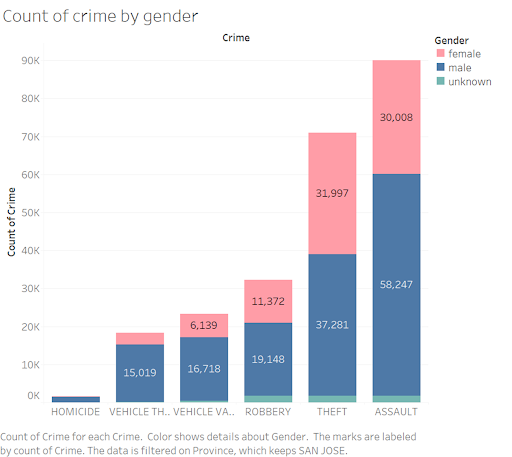

In [4]:
Image('EDA_1.png')

Most common crime in San Jose is Assault and Theft. A majority of crimes are committed against men.

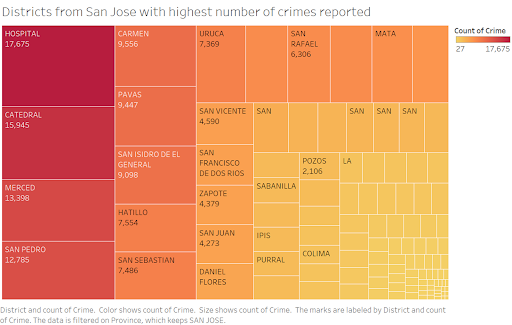

In [5]:
Image('EDA_2.png')

The top 10 districts with the most crimes are Hospital, Catedral, Merced, and San Pedro, Carmen, Pavas, San Isidro de el General, Hatillo, San Sebastian.

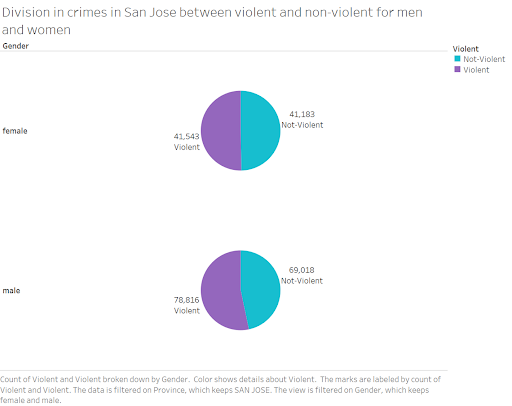

In [6]:
Image('EDA_3.png')

Crimes are almost evenly divided between non-violent (theft and vehicle crimes) and violent (everything else). However, when comparing between genders, men have a higher rate of suffering violent crimes.

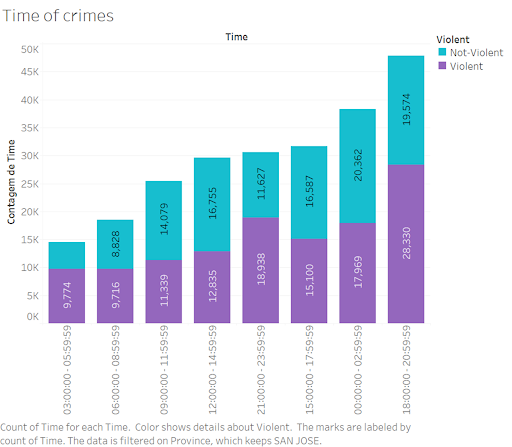

In [7]:
Image('EDA_4.png')

Most crimes occur between 18:00 and 20:00 (which has more violent crimes) and between 00:00 and 2:00 (which has more non-violent crimes).

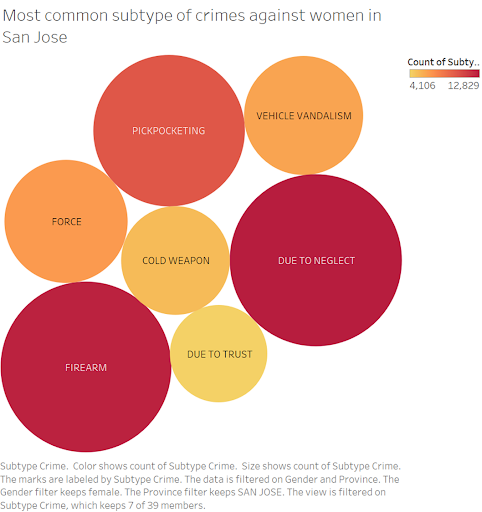

In [8]:
Image('EDA_5.png')

Women are more likely to suffer crimes of pickpocketing, firearms, and due to neglect.

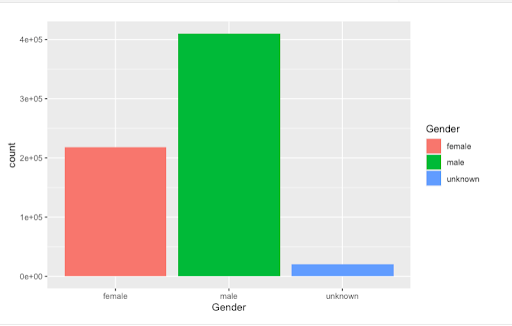

In [9]:
Image('EDA_9.png')

We can see from the graph, that males are more exposed to crimes than females which contradicts the literature. We can think that crimes directed to women are less reported than those directed to men and the reason behind it is a lack of reporting of violence against women either because the victims feel unsupported by the government and police force, they feel unsafe doing so or because they know nothing will be done.

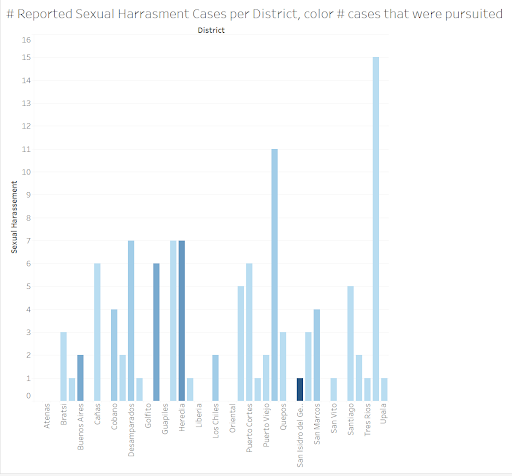

In [10]:
Image('EDA_6.png')

As one can see, all throughout Costa Rica, the number of sexual harrasment crimes persecuted is very low and unproportionate to the number of cases that are reported. In most of the districts, none of the cases were prosecuted. In San Isidrio del General there were eight pursuits, but that remains an outlier as the others have either 0 or 1 pursuits and Heredia has 4 and Grecia and Buenos Aires 3. In relation to the literature found, one can assume that because the percentage of cases reported and that are persecuted is very small, women are even less likely to report a case of gender-based violence if faced with this. That may also be the reason why almost 2/3 of the cases reported from 2010-2022 were reported by men. Women feel ngelected in Costa Rica and therefore are less likely to report a crime.

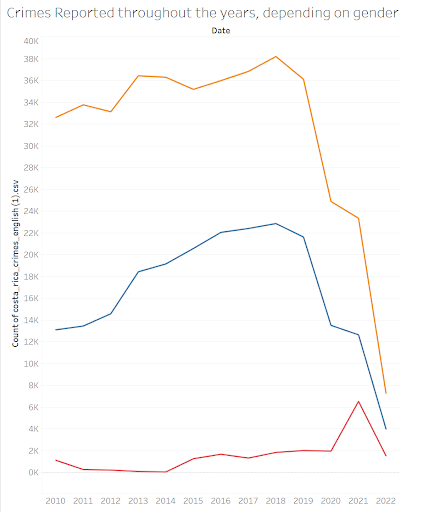

In [11]:
Image('EDA_7.png')

Throughout the years the number of cases reported has increased (up until COVID19 began) for all genders although there still remains a significant gap between number of cases reported by women and men.

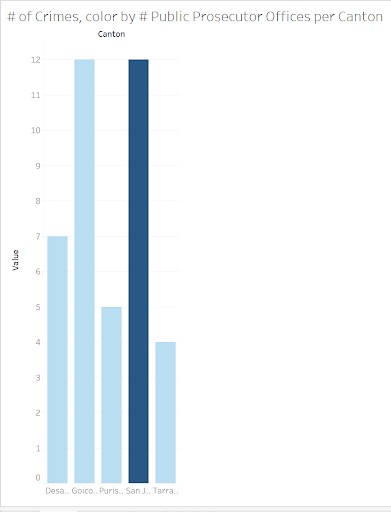

In [12]:
Image('EDA_8.png')

-Looking at the “Sexual Harrasment Laws in Districts” graph, it is discovered that only two of the 123 districts in San Jose,, this is only 0.016 of the districts, have sexual harrasment protection laws. This leaves women in the rest of the districts unprotected.

-Moving to the “# of Crimes, color by #Public Prosecutor Offices per Canton”, it is found that only one canton, San Jose, has more than one Prosecutor Office. This is unproportionate to the number of crimes in the cantones and also leaves individuals unprotected.


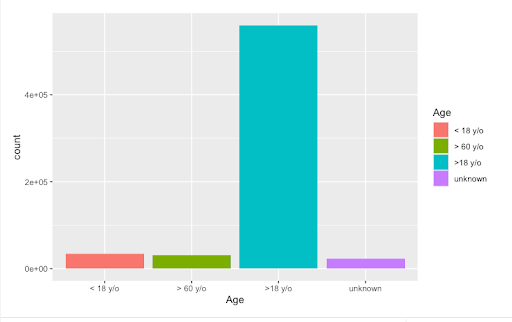

In [13]:
Image('EDA_10.png')

From the graph, we can see that most of the crimes are directed to individuals aged 18 or more.

### Loading and Preprocessing Data to Create Index (Incidents)

To tackle the challenge we decided to focus only on the province of San Jose. Additionally as we will need to calculate the crime index by year and quarter we added one column for each.

In [6]:
# Loading Dataset
crime = pd.read_csv("costa_rica_crimes_english.csv").iloc[
        :, 1:]

# Filtering only for Province of San Jose
crime = crime.loc[crime.Province == "SAN JOSE", :]

# Filtering out district named "Unknown"
crime = crime.loc[crime.District != "DESCONOCIDO", :]

# Turning Date column into Date type
crime.Date = pd.to_datetime(crime.Date, dayfirst=True)

# Adding Quarter as a column
crime.insert(2, "Quarter", crime.Date.dt.to_period("Q").astype(str))

# Adding Year as a column
crime.insert(2, "Year", crime.Date.dt.year)


**Weighting each Incident**

The most simple crime index possible would be to divide the total number of cases over the total population of a specific district in a specific point in time. However, this wouldn't account for the fact that not all crimes are equal. For instance, a homicide is a more severe crime than an assault and a crime against a minor is more severe than a crime against an adult. Additionally, because we are developing a crime index for women it makes sense to give a bigger weight to crimes committed against women.

To give an objective weight based on the type of crime committed, we took a look at the Criminal Code of Costa Rica to see how many years of prison corresponded to each type of 'SubtypeCrime'. The criminal code can be found here: https://www.oas.org/dil/esp/codigo_penal_costa_rica.pdf (it's in spanish).  The weight given to crimes committed against minors was decided to be x2 because in the Criminal Code of Costa Rica crimes against minors usually mean double the crime sentence. We decided to also use x2 for crimes against women. This method for creating the crime index is based on the Pinkerton Crime Index, the methodology for their index can be found in the following link: https://pinkerton.com/products/pinkerton-crime-index/methodology.


**Years of Prison according to the Criminal Code of Costa Rica**

**Assault**
- *Cold Weapon:*  2-6 months (Article 140)
- *Firearm:*     6-12 months  (Article 141)
- *Suffocation/Strangulation:* 3-10 years, 1-6 years, 3 months to a year, or 10-30 days depending on the severity (Articles 123, 124, 125, 387)
- *Hitting:* 3-10 years, 1-6 years, 3 months to a year, or 10-30 days depending on the severity (Articles 123, 124, 125, 387)
- *Immobilisation:* 3-10 years, 1-6 years, 3 months to a year, or 10-30 days depending on the severity (Articles 123, 124, 125, 387)
- *Outburst:* 3-10 years, 1-6 years, 3 months to a year, or 10-30 days depending on the severity (Articles 123, 124, 125, 387)
- *Verbal Intimidation:* 10-50 days (Article 145)
- *Undetermined:* Unknown
- *Use of Gas:* Unknown


**Homicide**
- *Unknown:* Unknown but we decided to put it under Article 111, thus 12-18 years
- *Professional Neglect:* 12-18 years (Article 111)
- *Ideological:* 12-18 years (Article 111)
- *Domestic Violence:* 20-35 years (Article 112.1)
- *Minors:*  20-35 years (Article 112.3)
- *For the commission of another crime:* 20-35 years (Article 112.8)
- *Avoiding Criminal activity:* 20-35 years (Article 112.8)
- *Femicide*: Unknown but we decided to put it under Article 112, thus 20-35 years
- *Argument/Fight:* 1-6 years, Article 113


**Robbery**
- *Breaking Windows:* 5-15 years (Article 213.1)
- *Breaking and entry:*  0.5-3 years or 1-6 years depending on the severity (Article 212.1)
- *Blinds Removal:*  0.5-3 years or 1-6 years depending on the severity (Article 212.1)
- *Cut Padlocks:*   0.5-3 years or 1-6 years depending on the severity (Article 212.1)
- *Unknown:* We can't tell but we are going to classify it under Article 212.1 as well
- *Escalation:* 3-9 years (Article 212.3)
- *Force:* 3-9 years (Article 212.3)


**Theft**
- *ATM Withdraw:*  1-3 years (Article 208)
- *Deceit/Distraction:* 1-3 years (Article 208)
- *Due to neglect:* 1-3 years (Article 208)
- *Due to trust:* 1-3 years (Article 208)
- *Pickpocketing:* 1-3 years (Article 208)
- *Progressive Thefts During the Day:* 1-3 years (Article 208)
- *Use of sleeping pills:* 1-3 years (Article 208)
- *With a wrench:* 1-3 years (Article 208)
- *Unknown:* We are going to classify it under Article 208 as well.
- *Picklock:* 1-3 years or 1_10 years depending on the value of the thing stolen (Article 209.3)


**Vehicle Theft**
- *Vehicle Theft:*  1-6 years (Article 212.2)
- *Unknown:* 1-6 years (Article 212.2)
- *Carjacking:* 1-6 years (Article 212.2)
- *Due to trust:* 1-6 years (Article 212.2)
- *Neglect:* 1-6 years (Article 212.2)
- *Assault:* 3-9 years (Article 212.3)


**Vehicle Vandalism**
- *Vehicle Vandalism:* 15 days to a year (Article 228)



In [7]:
# Obtaining the different types of crime
crime_types = crime.groupby(["Crime", "SubtypeCrime"]).size().reset_index().iloc[:, 0:2]

# Creating a list with the average prison sentence per crime (same order as 'crime_types')
sentence_length = [0.33, 0.75, 2.67, 2.67, 2.67, 2.67, 2.67, 2.67, 2.67, 0.1, 3.5, 27.5, 27.5, 27.5, 27.5, 15, 15, 15,
                   15, 15, 2.625, 2.625, 10, 2.625, 6, 6, 2.625, 2.625, 1.5, 1.5, 1.5, 1.5, 1.5, 3.75, 1.5, 1.5, 1.5,
                   1.5, 1.5, 6, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 0.5]
# Adding sentence length
crime_types["Approximate Sentence Length"] = sentence_length

# Displaying the type of crime and its average sentence length
crime_types

,Crime,SubtypeCrime,Approximate Sentence Length
0,ASSAULT,COLD WEAPON,0.330
1,ASSAULT,FIREARM,0.750
2,ASSAULT,HITTING,2.670
3,ASSAULT,IMMOBILIZATION,2.670
4,ASSAULT,OTHER OR UNDETERMINED,2.670
5,ASSAULT,OUTBURST,2.670
6,ASSAULT,SUFFOCATION/STRANGULATION,2.670
7,ASSAULT,UNKNOWN,2.670
8,ASSAULT,USE OF GAS,2.670
9,ASSAULT,VERBAL INTIMIDATION,0.100


**NOTE:** Code below takes a few minutes to run

In [8]:
# Function that will help us add the sentence length as a column in the 'crime' dataframe.
def prison_sentence(incident):
    crime = incident[0]
    subtypecrime = incident[1]
    sentence_length = float(
        crime_types.loc[(crime_types.Crime == crime) & (crime_types.SubtypeCrime == subtypecrime),].iloc[:, 2])
    return sentence_length


# Function that will help us add the gender weight for each incident as a column in the 'crime' dataframe.
def gender_weight(gender):
    if (gender == "female"):
        return 2
    else:
        return 1


# Function that will help us add the age weight for each incident as a column in the 'crime' dataframe.
def age_weight(age):
    if (age == "< 18 y/o"):
        return 2
    else:
        return 1


# Applying the functions created to the 'crime' dataframe.
crime.insert(2, "Approximate_Prison_Sentence", crime.iloc[:, 0:2].apply(prison_sentence, axis=1, result_type="reduce"))
crime.insert(9, "Age_Weight", crime.Age.apply(age_weight))
crime.insert(11, "Gender_Weight", crime.Gender.apply(gender_weight))

# Calculating the weight/index of each incidence by multiplying the three columns we just created
incidence_index = crime.Approximate_Prison_Sentence * crime.Age_Weight * crime.Gender_Weight

# Adding the incidence index as a column in 'crime'
crime["incidence_index"] = incidence_index

Our crime index will take the sum of the incidence index for each district at each quarter and divide this number by the population of each district at that point in time. That way the index captures the frequency and severity of incidents but also takes into account the size of the population in that area.

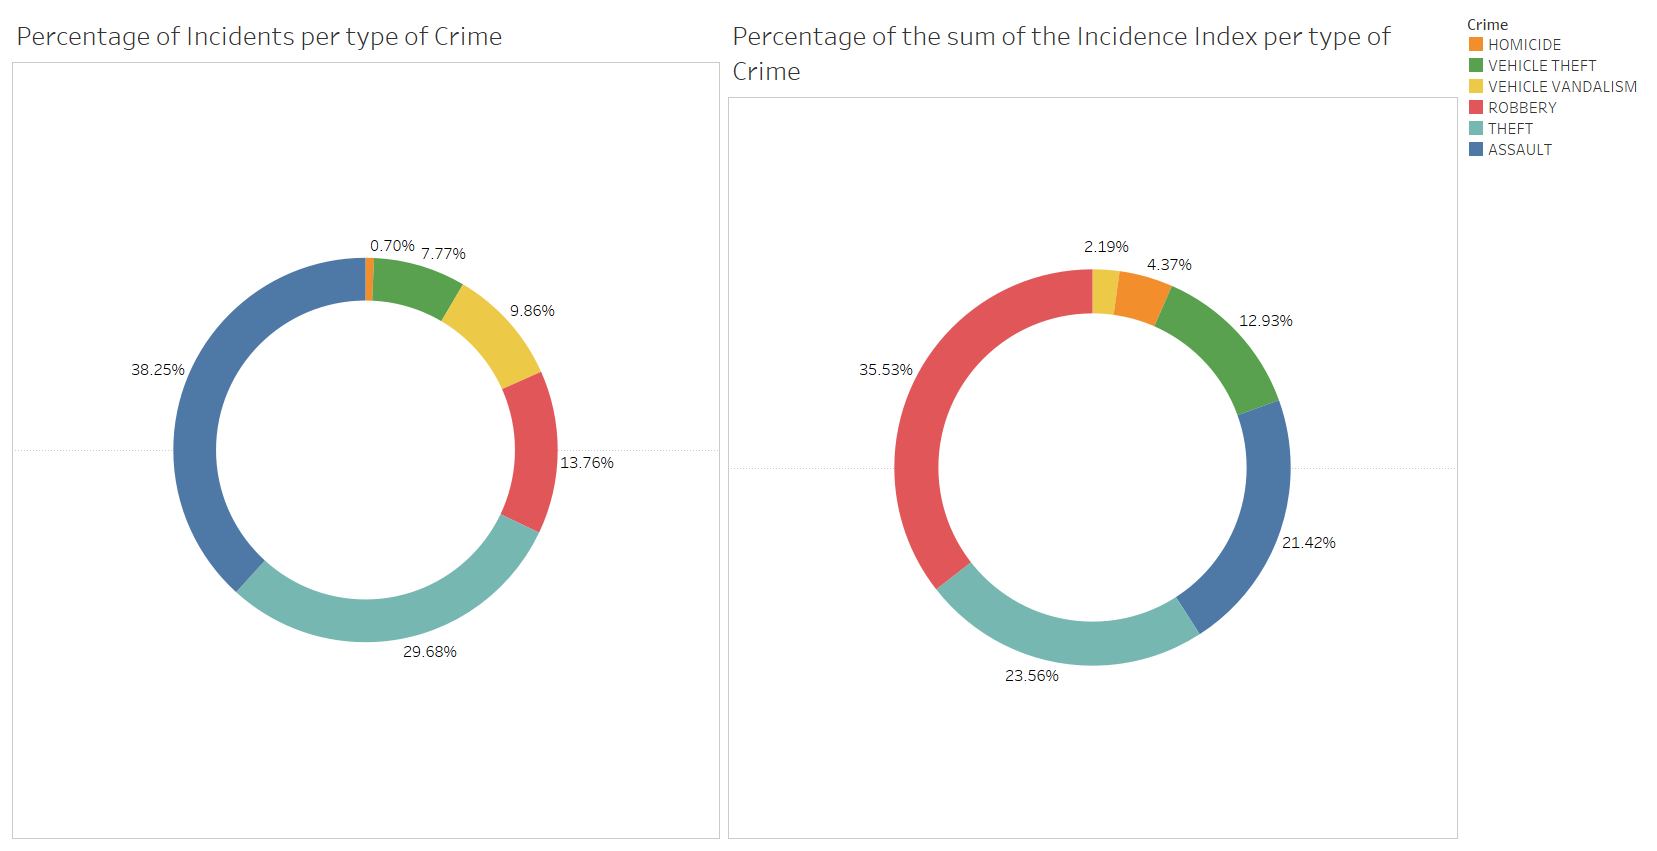

In [12]:
Image('Crime_Distribution.png')

We can see that after weighting the incidents there is a change for the most relevant types of crime as compared to just counting the number of crime. For instance, as should be the case, the importance of homicide cases grw from just 0.7% to 4.37%. The importance give to vehicle vandalism decreased from 9.86% to 2.19%. Another important change can be seen from how robbery changed from 13.76% to 35.53% whilst assault decreased from 38.25% to 21.42%. It is important to note that the second diagram might differ if we had more information on each crime because in the cases (like in some of the assault subtypes) the prison sentence was based on the severity of the assault but because we have no information of the severity we just took the average of the different possible prison sentences for that type of crime.

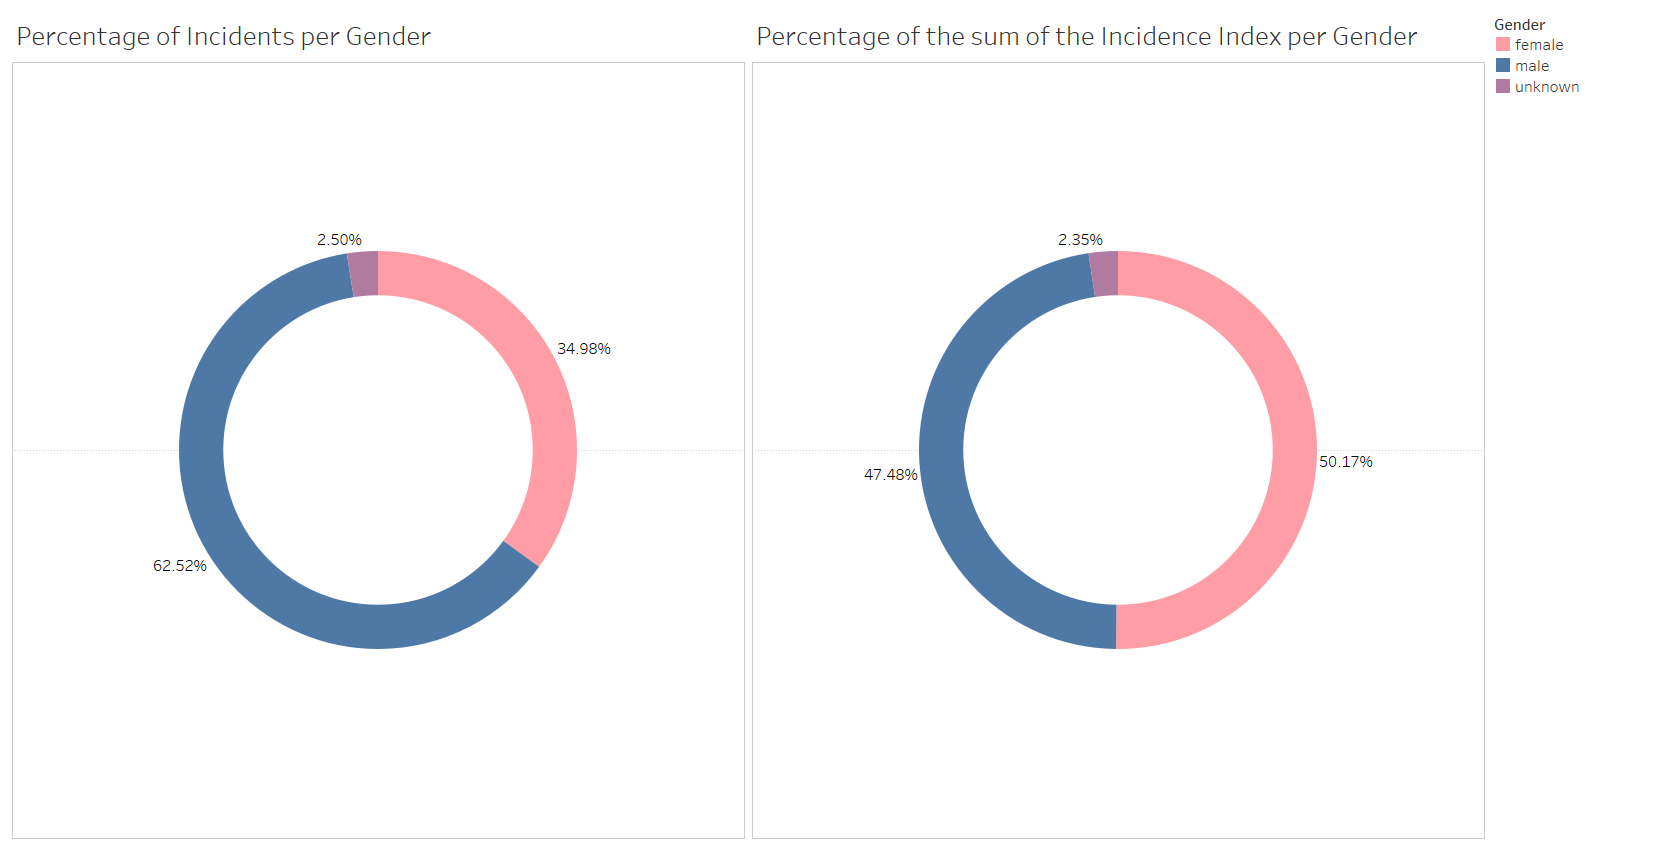

In [14]:
Image('Gender_Distribution.png')

We can see from the donut charts above that weighting the incidents and given a bigger weight to female victims also changed the importance given to each gender making it more equal. If we found information of the percentage of cases that go unreported by men and by women we could a more accurate weighting.

### Loading and Preprocessing Data to Create Index (Population)

The population datasets were taken from Costa Rica's INEC (National Institute of Statistics and Census). The first dataset will be used to extract information for the year 2010 and the second dataset to extract information for the years 2011-2022. This is the link were the data was found and where it can be downloaded: https://www.inec.go.cr/poblacion/estimaciones-y-proyecciones-de-poblacion .

As the datasets are formatted in an undesired way, we first needed to create a function to extract all the data and formatted in the way that we can use it.

In [15]:
# defining function to format population data
def population_clean(file, years):
    # creating an empty dataframe to add on to
    column_names = {"Year": [], "Canton": [], "District": [], "Population": []}
    final_df = pd.DataFrame(column_names)

    # we want to extract data from multiple years at the same time
    for year in years:
        # loading data
        df = pd.read_excel(file, sheet_name=str(year))

        # filtering the necessary columns
        df = df.iloc[10:151, 1:3]
        df.columns = ["District", "Population"]

        # the cantons and districts were in the same column so we needed to extract them to treat them separetly
        canton_positions = [0, 12, 16, 30, 40, 44, 52, 59, 67, 74, 80, 86, 92, 98, 102, 107, 113, 117, 122, 134]
        cantons = df.iloc[canton_positions, 0]
        df = df.drop(df.index[[canton_positions]])
        df = df.reset_index().drop("index", axis=1)

        # creating a Series that contains the name of the canton for each district
        canton_column = np.repeat([cantons], [11, 3, 13, 9, 3, 7, 6, 7, 6, 5, 5, 5, 5, 3, 4, 5, 3, 4, 11, 6])

        # creating a Series that contains the year of the data point
        year_column = np.repeat(year, 121)
        df["Canton"] = canton_column
        df["Year"] = year_column
        df = df.loc[:, ["Year", "Canton", "District", "Population"]]

        # adding the dataframe created in the for loop to the one that will be outputted
        final_df = pd.concat([final_df, df])

    final_df.Year = final_df.Year.astype("int")
    # The Canton and District in 'crime' dataframe are all written in upper and have no spanish symbols.
    # We need the string format to be the same thus we reformatted them for the population datasets.
    final_df.Canton = final_df.Canton.str.upper().str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode(
        'utf-8')
    final_df.District = final_df.District.str.upper().str.normalize('NFKD').str.encode('ascii',
                                                                                       errors='ignore').str.decode(
        'utf-8')
    return final_df


# Running the function on the datasets
population_2010 = population_clean("repoblacev2000-2011-04.xlsx", years=[2010])
years = [year for year in range(2011, 2023)]
population_2011_2022 = population_clean("repoblacev2011-2025-03.xlsx", years=years)

# Concatenating both dataframes to have information of 2010-2022 in a single dataframe
population = pd.concat([population_2010, population_2011_2022]).reset_index().drop("index", axis=1)

# Displaying the dataframe
population

,Year,Canton,District,Population
0,2010,SAN JOSE,CARMEN,3190
1,2010,SAN JOSE,MERCED,13934
2,2010,SAN JOSE,HOSPITAL,21577
3,2010,SAN JOSE,CATEDRAL,14749
4,2010,SAN JOSE,ZAPOTE,20623
...,...,...,...,...
1568,2022,LEON CORTES,SAN ANDRES,1746
1569,2022,LEON CORTES,LLANO BONITO,2269
1570,2022,LEON CORTES,SAN ISIDRO,1870
1571,2022,LEON CORTES,SANTA CRUZ,2164


After this we needed to make sure that all the districts in 'crime' are also in 'population'.

In [16]:
list([set(crime.District) - set(population.District), (set(population.District) - set(crime.District))])

[{'CANDELARITA',
  'LA AMISTAD',
  'LA LEGUA',
  'LA TRINIDAD',
  'MATA PLATANO',
  'MONTERRY',
  'QUITIRRISÃ\x8d'},
 {'CANDELARIA', 'LEGUA', 'MATA DE PLATANO', 'MONTERREY', 'TRINIDAD'}]

We see that a few are still written differently despite reformatting the strings and that there are two districts that don't appear in 'population' but do appear in 'crime' : Quitirrisi and La Amistad. Therefore, we needed to change the names in one of the dataframes and add the two new districts to 'population'. For the population of Quitirrisi and La Amistad we could only find the population data from a report by INEC in 2017, therefore, we are going to assume that the populations from 2010-2022 is the same as that in 2017 for these two districts. The population for Quitirrisi and Amistad were found here: https://www.inec.cr/sites/default/files/documetos-biblioteca-virtual/repoblacev2017_0.pdf .

In [17]:
# Creating function to change names
def change_district_name(district):
    if (district == "CANDELARITA"):
        return "CANDELARIA"
    elif (district == "LA LEGUA"):
        return "LEGUA"
    elif (district == "MATA PLATANO"):
        return "MATA DE PLATANO"
    elif (district == "MONTERRY"):
        return "MONTERREY"
    elif (district == "LA TRINIDAD"):
        return "TRINIDAD"
    elif (district == "QUITIRRISÃ\x8d"):
        return "QUITIRRISI"
    else:
        return district


# applying the function to 'crime'
crime.District = crime.District.apply(change_district_name)

# creating rows for the two missing districts
missing_districts = pd.DataFrame({"Year": np.repeat([range(2010, 2023), range(2010, 2023)], 1),
                                  "Canton": np.repeat(["PEREZ ZELEDON", "MORA"], [13, 13]),
                                  "District": np.repeat(["LA AMISTAD", "QUITIRRISI"], [13, 13]),
                                  "Population": np.repeat([2837, 1850], [13, 13])})

# adding the rows to 'population'
population = pd.concat([population, missing_districts]).reset_index().drop("index", axis=1)

We also needed to check if we would find the same issue for Canton.

In [18]:
list([set(crime.Canton) - set(population.Canton), (set(population.Canton) - set(crime.Canton))])

[{'VASQUEZ DE CORONADO'}, {'VAZQUEZ DE CORONADO'}]

In this case we just have one Canton that is written differently and we have to change it.

NOTE: We are keeping canton because some of the districts are called the same but are in a different Canton so we need this column in order to be able to make that distinction.

In [19]:
def change_canton_name(canton):
    if (canton == 'VASQUEZ DE CORONADO'):
        return 'VAZQUEZ DE CORONADO'
    else:
        return canton


crime.Canton = crime.Canton.apply(change_canton_name)

### Calculating index by Year

We are going to calculate the index first by year and then by quarter.

In [20]:
# We need to remove 2022 because the information is not about the whole year.
yearly_population = population.loc[(population.Year != 2022), :]

# calculating the sum of the incidence index per year, per district
yearly_sum_of_incidence = crime.loc[(crime.Year != 2022), :].groupby(["Year", "Canton", "District"]).agg(
    {"incidence_index": "sum"}).reset_index()

# Merging both 'yearly_population' and 'yearly_sum_of_incidence' and rearranging columns
yearly_index = pd.merge(yearly_population, yearly_sum_of_incidence, how='left', left_on=['Year', 'Canton', 'District'],
                        right_on=['Year', 'Canton', 'District']).loc[:,
               ["Year", "Canton", "District", "incidence_index", "Population"]]

# Some districts may have no incidents in some years so the line above will return null values which have to be changed to 0
yearly_index.incidence_index = yearly_index.incidence_index.fillna(0)
yearly_index.rename(columns={"incidence_index": "Sum_of_Incidence_Index"}, inplace=True)

# Calculating the raw crime index
yearly_index["Raw_Crime_Index"] = yearly_index.Sum_of_Incidence_Index / yearly_index.Population

With this method, the values of the raw crime index are very small and hard to interpret. Therefore, to solve this we decided to modify the index in such a way that it is easy to compare. We are first going to calculate the raw index for the whole province of San Jose each year and then take the raw crime index of each district and divide it by the raw index of San Jose in the corresponding year.

In [21]:
# Calculating the sum of incidence and population for San Jose each year
sanjose_yearly_index = yearly_index.groupby("Year").agg({"Sum_of_Incidence_Index": "sum", "Population": "sum"})

# Calculation the raw crime index for San Jose each year
sanjose_yearly_index["Raw_Crime_Index"] = sanjose_yearly_index.Sum_of_Incidence_Index / sanjose_yearly_index.Population
sanjose_yearly_index = sanjose_yearly_index.iloc[:, 2]

In [22]:
# creating function to calculate crime index based on San Jose's raw index each year
def yearly_index_calculator(row):
    sanjose = sanjose_yearly_index[row[0]]
    crime_index = row[5] / sanjose
    return crime_index

# applying the function to 'yearly_index'
yearly_index["Crime_Index"] = yearly_index.apply(yearly_index_calculator, axis=1, result_type="reduce")

# Displaying yearly_index
yearly_index

,Year,Canton,District,Sum_of_Incidence_Index,Population,Raw_Crime_Index,Crime_Index
0,2010,SAN JOSE,CARMEN,1662.300,3190,0.521097,16.123031
1,2010,SAN JOSE,MERCED,2264.930,13934,0.162547,5.029293
2,2010,SAN JOSE,HOSPITAL,2464.090,21577,0.1142,3.533405
3,2010,SAN JOSE,CATEDRAL,3052.635,14749,0.206972,6.403837
4,2010,SAN JOSE,ZAPOTE,792.865,20623,0.038446,1.189530
...,...,...,...,...,...,...,...
1471,2017,MORA,QUITIRRISI,0.000,1850,0.0,0.000000
1472,2018,MORA,QUITIRRISI,0.000,1850,0.0,0.000000
1473,2019,MORA,QUITIRRISI,21.250,1850,0.011486,0.287452
1474,2020,MORA,QUITIRRISI,47.250,1850,0.025541,1.008280


Now the index is very easy to interpret. For instance if we take the district Carmen in 2010 we can see that the crime index is 16.1, this means that Carmen was 16 times more dangerous than the average of San Jose in 2010.

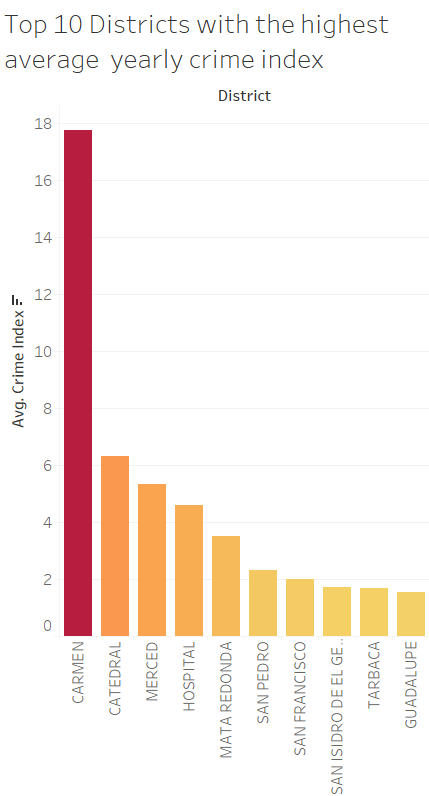

In [33]:
Image('Most Dangerous.png')

If we recall the EDA the top 10 districts with the most crimes are Hospital, Catedral, Merced, and San Pedro, Carmen, Pavas, San Isidro de el General, Hatillo, San Sebastian in that order. We can see that now that we take into account both the weighting of each incident and the population of each district there is a change in the most dangerous districts. For instance, we can see that Carmen used to be 5th but with our index it is the most dangerous district by far. Moreover, even though hospital had the most crimes it ranks fourth in the average yearly crime index. This bar plot, thus, shows a more accurate representation of the most dangerous districts in San Jose.

### Calculating index by Quarter

To calculate the Quarterly index we take the same approach but this time we also need to add a column with the Quarter into the population dataframe. As we didn't find any datasets containing the population by quarter we are going to assume the population stays the same throughout the year.

In [27]:
# Adding Quarter column to population
population_q1 = population.copy()
population_q1["Quarter"] = "Q1"
population_q1.Quarter = population_q1.Year.astype(str) + population_q1.Quarter

population_q2 = population.copy()
population_q2["Quarter"] = "Q2"
population_q2.Quarter = population_q2.Year.astype(str) + population_q2.Quarter
population_q2 = population_q2.loc[population_q2.Year != 2022, :] # we haven't finished the 2nd Quarter of 2022 so we remove it

population_q3 = population.copy()
population_q3["Quarter"] = "Q3"
population_q3.Quarter = population_q1.Year.astype(str) + population_q3.Quarter
population_q3 = population_q3.loc[population_q3.Year != 2022, :] # we haven't reached the 3rd Quarter of 2022 so we remove it

population_q4 = population.copy()
population_q4["Quarter"] = "Q4"
population_q4.Quarter = population_q4.Year.astype(str) + population_q4.Quarter
population_q4 = population_q4.loc[population_q4.Year != 2022, :] # we haven't reached the 4th Quarter of 2022 so we remove it

# putting the dataframes for each quarter together.
quarterly_population = pd.concat([population_q1, population_q2, population_q3, population_q4])

Now we can calculate the quarterly index:

In [28]:
# calculating the sum of the incidence index per quarter, per district
quarterly_sum_of_incidence = crime.groupby(["Year", "Quarter", "Canton", "District"]).agg(
    {"incidence_index": "sum"}).reset_index()

# Merging both 'yearly_population' and 'yearly_sum_of_incidence' and rearranging columns
quarterly_index = pd.merge(quarterly_population, quarterly_sum_of_incidence, how='left',
                           left_on=['Year', 'Quarter', 'Canton', 'District'],
                           right_on=['Year', 'Quarter', 'Canton', 'District']).loc[:,
                  ["Year", "Quarter", "Canton", "District", "incidence_index", "Population"]]

# Some districts may have no incidents in some quarters so the line above will return null values which have to be changed to 0
quarterly_index.incidence_index = quarterly_index.incidence_index.fillna(0)
quarterly_index.rename(columns={"incidence_index": "Sum_of_Incidence_Index"}, inplace=True)

# Calculating raw crime index
quarterly_index["Raw_Crime_Index"] = quarterly_index.Sum_of_Incidence_Index / quarterly_index.Population

In [29]:
# Calculating the sum of incidence and population for San Jose each quarter
sanjose_quarterly_index = quarterly_index.groupby("Quarter").agg({"Sum_of_Incidence_Index": "sum", "Population": "sum"})

# Calculation the raw crime index for San Jose each year
sanjose_quarterly_index[
    "Raw_Crime_Index"] = sanjose_quarterly_index.Sum_of_Incidence_Index / sanjose_quarterly_index.Population
sanjose_quarterly_index = sanjose_quarterly_index.iloc[:, 2]

In [30]:
# creating function to calculate crime index based on San Jose's raw index each quarter
def quarterly_index_calculator(row):
    sanjose = sanjose_quarterly_index[row[1]]
    crime_index = row[6] / sanjose
    return crime_index


# applying the function to 'quarterly_index'
quarterly_index["Crime_Index"] = quarterly_index.apply(quarterly_index_calculator, axis=1, result_type="reduce")

# Displaying 'quarterly_index'
quarterly_index

,Year,Quarter,Canton,District,Sum_of_Incidence_Index,Population,Raw_Crime_Index,Crime_Index
0,2010,2010Q1,SAN JOSE,CARMEN,478.035,3190,0.149854,17.780047
1,2010,2010Q1,SAN JOSE,MERCED,545.345,13934,0.039138,4.643649
2,2010,2010Q1,SAN JOSE,HOSPITAL,589.530,21577,0.027322,3.241744
3,2010,2010Q1,SAN JOSE,CATEDRAL,845.285,14749,0.057311,6.799930
4,2010,2010Q1,SAN JOSE,ZAPOTE,224.290,20623,0.010876,1.290393
...,...,...,...,...,...,...,...,...
6022,2017,2017Q4,MORA,QUITIRRISI,0.000,1850,0.0,0.000000
6023,2018,2018Q4,MORA,QUITIRRISI,0.000,1850,0.0,0.000000
6024,2019,2019Q4,MORA,QUITIRRISI,0.000,1850,0.0,0.000000
6025,2020,2020Q4,MORA,QUITIRRISI,1.500,1850,0.000811,0.130070


Once again, the index is now easy to interpret. If we take the second value as an example we can interpret that in the first quarter of 2010 Merced was 4.64 times as dangerous as the average of the province of San Jose.

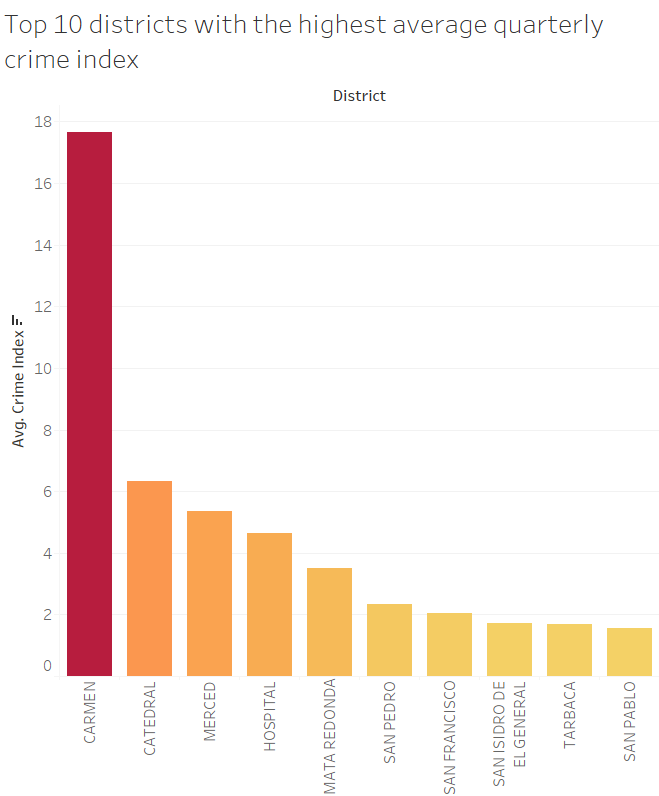

In [34]:
Image('Most Dangerous 2.png')

Once again we can see that the top 10 most dangerous districts are different than the ones shown in the EDA. The top 10 most dangerous according to the average quarterly and yearly indexes is almost the same with the exception of the 10th position, were Guadalupe is the 10th in the yearly index but San Pablo is the 10th in the quarterly index.

### Experimenting with different models for prediction

First we built a time series model for using the quarterly index.

NOTE: before cross-validating any model we decided to use the data of 2019 and beyond as the test data and everything before that as the training data.

In [29]:
# filtering for the columns to be used
data = quarterly_index.loc[:, ["Quarter", "Canton", "District", "Population", "Crime_Index"]]

# creating column with date to set as index in the time series
data['Date'] = pd.to_datetime(data.Quarter).dt.to_period('Q')

# this function will extract for instance 'Q3' from string '2020Q3' to add the quarter as a seasonal feature
def quarter_extract(quarter):
    return (quarter[4:6])

data.Quarter = data.Quarter.apply(quarter_extract)

# dummy variables for the quarter column
encoder = OneHotEncoder(cols=['Quarter'])
data = encoder.fit_transform(data)

In [30]:
# creating columns for the dataframe that the model will input
data_test = pd.DataFrame({'Canton': [], 'District': [], 'Crime_Index': [], 'Prediction': []})

# creating a model for each district (we group by Canton as well because some districts have the same name)
for canton_district, df_district in data.groupby(['Canton', 'District']):

    #  setting date as index and dropping the 'Quarter_1 dummy variable
    df_district = df_district.sort_values(by='Date').set_index("Date").loc[:,
                  ['Crime_Index', 'Quarter_2', 'Quarter_3', 'Quarter_4']]

    # creating the trend feature for the model
    dp = DeterministicProcess(index=df_district.index, constant=True, order=1, drop=True)
    df_district = df_district.join(dp.in_sample())

    # testing for the partial autocorrelation of the first lag to see if it's significant and if so add it as a feature
    if (abs(pacf(df_district.Crime_Index)[1]) > 0.2):
        df_district['Lag_1'] = df_district.Crime_Index.shift(1)
    df_district.dropna(inplace=True)

    # creating train and test data
    train = df_district.loc[df_district.index <= pd.Period('2018Q3', freq='Q'), :]
    test = df_district.loc[df_district.index >= pd.Period('2019Q1', freq='Q'), :]
    X_train = train.drop(['Crime_Index'], axis=1)
    X_test = test.drop(['Crime_Index'], axis=1)
    y_train = train.Crime_Index
    y_test = test.Crime_Index

    # creating and fitting the regression model
    reg = LinearRegression(fit_intercept=False)
    reg = reg.fit(X_train, y_train)
    y_pred = reg.predict(X_test)

    # putting everything together into a single dataset 'data_test'
    test['Prediction'] = y_pred
    test['Canton'] = canton_district[0]
    test['District'] = canton_district[1]
    test = test.loc[:, ['Canton', 'District', 'Crime_Index', 'Prediction']]
    data_test = pd.concat([data_test, test])

In [31]:
# as some predictions are negative and because of our methodology the smallest value for the crime index is 0 we change negatives to 0s
def n_to_0(prediction):
    if prediction < 0:
        return 0
    else:
        return prediction

# model performance
mean_squared_error(data_test.Crime_Index, data_test.Prediction.apply(n_to_0), squared=False)

0.8109862883502904

The root mean squared error is 0.81. We are going to compare the other models against this performance. Even though the error is relatively small we realized that even thought is a good approach to calculate the quarterly index it wouldn't really work to predict the yearly index as we would only have around 10 data points per district. Therefore, in the following models we decided to take a different approach and train the models using data per month.

### Creating Data to predict the incidence index by month

The following models will actually predict the sum of the incidence index and not the crime index but predicting the sum of the incidence index for each district per quarter or year wil still make it possible to predict the crime index as will be shown in the next subsection. But before anything else we needed to prepare the dataframe that will be inputted into the models.

In [32]:
# creating a new column for month in the crime dataset to later aggregate it by month
crime['Month'] = crime.Date.dt.to_period("M")
# we exclude data from the 2nd Quarter of 2022 cause it hasn't finished
crime = crime.loc[(crime.Quarter != '2022Q2'), :]


# creating a dataframe tha contains all years and all months for every district
# this is necessary because in some months no crime happened in some districts so without this no data would exist for this months
# instead we will end up having 0 for those months instead of not taking them into account
year_month = pd.DataFrame({"Year": [], "Month": [], "Canton": [], "District": []})
for i in range(1, 13):
    year = population.iloc[:, 0:3] # we use this dataset because it already is in the format that we want
    year['Month'] = i
    year = year.loc[:, ['Year', 'Month', 'Canton', 'District']]
    year_month = pd.concat([year_month, year])

# we also exclude any information after the first quarter of 2022 in this dataframe
year_month = year_month.loc[((year_month.Year == 2022) & (year_month.Month > 3)) == False, :]
year_month.Month = year_month.Month.astype('int64')

# aggregating the incidence index by month
data = crime.groupby(['Month', 'Canton', 'District']).agg({'incidence_index': 'sum'}).reset_index()

# creating a Date column to later index
data['Date'] = data.Month

# creating year column
data['Year'] = data.Month.dt.year.astype(float)

# changing from period to integer to later create a dummy variable
data.Month = data.Month.dt.month

# merging the 'year_month' and 'data' dataframes as they are now both in the same format
data = pd.merge(year_month, data, how='left', on=['Year', 'Month', 'Canton', 'District'])
data.incidence_index = data.incidence_index.fillna(0)
data['Day'] = 1 # this is just done to help us create the Date as a month Period type
data.Date = pd.to_datetime(data[['Year', 'Month', 'Day']], yearfirst=True).dt.to_period("M")
data = data.drop(['Year', 'Day'], axis=1)

# creating dummy variables for month
encoder2 = OneHotEncoder(cols=['Month'])
data = encoder2.fit_transform(data)

### Function to transform the monthly predictions of incidence index into the crime index

As the predictions of the models will output the sum of the incidence index and not the crime index itself we first needed to create a function that would convert this predictions into the crime index (quarterly and yearly). This is a valid approach because to calculate the raw crime index we only need the sum of the incidence index and the population and because we have the predictions for the population until 2025 this approach could actually be used to make predictions until 2025 which is more than sufficient. Therefore, the following function will take the predictions of incidence index, calculate the raw crime index (the real one and predicted one) and then do the same for each district and finally convert it into the comparative crime index that was developed before.

In [33]:
def convert_predictions(data_test, quarter_year):
    if quarter_year == "quarter":
        # calculating the raw crime index by district and quarter
        quarterly_index_test = data_test.groupby(['Quarter', 'Canton', 'District']).agg(
            {'incidence_index': 'sum', 'Prediction': 'sum'}).reset_index()
        quarterly_index_test = quarterly_index_test.merge(quarterly_population, how='left',
                                                          on=['Quarter', 'Canton', 'District'])
        quarterly_index_test['raw_index_true'] = quarterly_index_test.incidence_index / quarterly_index_test.Population
        quarterly_index_test['raw_index_pred'] = quarterly_index_test.Prediction / quarterly_index_test.Population

        # Calculation of the raw crime index for the province of San Jose per quarter
        sanjose_quarterly_index_test = quarterly_index_test.groupby("Quarter").agg(
            {"incidence_index": "sum", "Population": "sum", "Prediction": "sum"})
        sanjose_quarterly_index_test[
            "raw_crime_index_true"] = sanjose_quarterly_index_test.incidence_index / sanjose_quarterly_index_test.Population
        sanjose_quarterly_index_test[
            "raw_crime_index_pred"] = sanjose_quarterly_index_test.Prediction / sanjose_quarterly_index_test.Population

        # creating function to calculate crime index based on San Jose's raw index each quarter
        def quarterly_index_calculator(row, type):
            if type == 'true':
                sanjose = sanjose_quarterly_index_test.loc[row[0], "raw_crime_index_true"]
                crime_index = row[7] / sanjose
                return crime_index
            elif type == 'pred':
                sanjose = sanjose_quarterly_index_test.loc[row[0], "raw_crime_index_pred"]
                crime_index = row[8] / sanjose
                return crime_index

        # applying the function 'quarterly_index_calculator' on the real data and on the predictions
        quarterly_index_test["Crime_Index_True"] = quarterly_index_test.apply(quarterly_index_calculator, type='true',
                                                                              axis=1,
                                                                              result_type="reduce")
        quarterly_index_test["Crime_Index_Pred"] = quarterly_index_test.apply(quarterly_index_calculator, type='pred',
                                                                              axis=1,
                                                                              result_type="reduce").apply(n_to_0) # converting any negatives to 0

        # Extracting only the columns that we want
        quarterly_index_test = quarterly_index_test.loc[:,
                               ["Quarter", "Canton", "District", "Crime_Index_True", "Crime_Index_Pred"]]

        return quarterly_index_test

    # the same as above but yearly
    elif quarter_year == "year":
        # calculating the raw crime index by district and year
        yearly_index_test = data_test.groupby(['Year', 'Canton', 'District']).agg(
            {'incidence_index': 'sum', 'Prediction': 'sum'}).reset_index()
        yearly_index_test = yearly_index_test.loc[yearly_index_test.Year != 2022, :]
        yearly_index_test = yearly_index_test.merge(yearly_population, how='left',
                                                    on=['Year', 'Canton', 'District'])
        yearly_index_test['raw_index_true'] = yearly_index_test.incidence_index / yearly_index_test.Population
        yearly_index_test['raw_index_pred'] = yearly_index_test.Prediction / yearly_index_test.Population

        # Calculation of the raw crime index for the province of San Jose per year
        sanjose_yearly_index_test = yearly_index_test.groupby("Year").agg(
            {"incidence_index": "sum", "Population": "sum", "Prediction": "sum"})
        sanjose_yearly_index_test[
            "raw_crime_index_true"] = sanjose_yearly_index_test.incidence_index / sanjose_yearly_index_test.Population
        sanjose_yearly_index_test[
            "raw_crime_index_pred"] = sanjose_yearly_index_test.Prediction / sanjose_yearly_index_test.Population

        # creating function to calculate crime index based on San Jose's raw index each year
        def yearly_index_calculator(row, type):
            if type == 'true':
                sanjose = sanjose_yearly_index_test.loc[row[0], "raw_crime_index_true"]
                crime_index = row[6] / sanjose
                return crime_index
            elif type == 'pred':
                sanjose = sanjose_yearly_index_test.loc[row[0], "raw_crime_index_pred"]
                crime_index = row[7] / sanjose
                return crime_index

        # applying the function 'yearly_index_calculator' for the real and predicted data
        yearly_index_test["Crime_Index_True"] = yearly_index_test.apply(yearly_index_calculator, type='true', axis=1,
                                                                        result_type="reduce")
        yearly_index_test["Crime_Index_Pred"] = yearly_index_test.apply(yearly_index_calculator, type='pred', axis=1,
                                                                        result_type="reduce").apply(n_to_0) # converting any negatives to 0
        # Extracting only the columns that we want
        yearly_index_test = yearly_index_test.loc[:,
                            ["Year", "Canton", "District", "Crime_Index_True", "Crime_Index_Pred"]]

        return yearly_index_test

### Time Series with Linear Regression Model

This model is very similar to the first one but this time it makes predictions per month for the sum of the incidence index. We also added additional parameters that will help us later to make the cross-validation of the model.

In [34]:
def time_series_model(data, train_last_date, test_first_date, quarter_year, test_last_date='2022-03', train_first_date = '2010-01'):
    data_test = pd.DataFrame(
        {'Year': [], 'Quarter': [], 'Canton': [], 'District': [], 'incidence_index': [], 'Prediction': []})


    for canton_district, df_district in data.groupby(['Canton', 'District']):
        # setting the date as index and dropping the 'Month_1' dummy variable
        df_district = df_district.sort_values(by='Date').set_index("Date").drop(['Canton', 'District', 'Month_1'],
                                                                                axis=1)
        # creting the trend as a feature
        dp = DeterministicProcess(index=df_district.index, constant=True, order=1, drop=True)
        df_district = df_district.join(dp.in_sample())

        # creating the lags a new column if they are significant
        if (abs(pacf(df_district.incidence_index)[1]) > 0.1):
            df_district['Lag_1'] = df_district.incidence_index.shift(1)
        if (abs(pacf(df_district.incidence_index)[2]) > 0.1):
            df_district['Lag_2'] = df_district.incidence_index.shift(2)
        if (abs(pacf(df_district.incidence_index)[3]) > 0.1):
            df_district['Lag_3'] = df_district.incidence_index.shift(3)
        df_district.dropna(inplace=True)

        # dividing the data into train and test data based on the desired dates
        # NOTE: the last date for the train data should always be three months less than first date of the test data because of the lags
        train = df_district.loc[ (df_district.index >= pd.Period(train_first_date, freq='M'))& (df_district.index <= pd.Period(train_last_date, freq='M')), :]
        test = df_district.loc[(df_district.index >= pd.Period(test_first_date, freq='M')) & (
                df_district.index <= pd.Period(test_last_date, freq='M')), :]
        X_train = train.drop(['incidence_index'], axis=1)
        X_test = test.drop(['incidence_index'], axis=1)
        y_train = train.incidence_index

        # creating and  fitting the model and then predicting
        reg = LinearRegression(fit_intercept=False)
        reg = reg.fit(X_train, y_train)
        y_pred = reg.predict(X_test)

        # creating the dataframe that wil be outputted
        test['Prediction'] = y_pred
        test['Canton'] = canton_district[0]
        test['District'] = canton_district[1]
        test['Quarter'] = pd.PeriodIndex(test.index, freq='Q').astype(str)
        test['Year'] = test.index.year.astype('int32')
        test = test.loc[:, ['Year', 'Quarter', 'Canton', 'District', 'incidence_index', 'Prediction']]

        # joining all of the predictions for every district
        data_test = pd.concat([data_test, test])

    # returning the dataframe after converting the incidence index predictions into the crime index
    return convert_predictions(data_test, quarter_year)

In [48]:
test_quarter = time_series_model(data, train_last_date="2018-09", test_first_date="2019-01", quarter_year='quarter')
test_year = time_series_model(data, train_last_date="2018-09", test_first_date="2019-01", quarter_year='year')

In [49]:
mean_squared_error(test_quarter.Crime_Index_True, test_quarter.Crime_Index_Pred, squared=False)

0.734206224223324

In [50]:
mean_squared_error(test_year.Crime_Index_True, test_year.Crime_Index_Pred, squared=False)

0.4816893704757374

We can see that there is a significant improvement in the performance of this model as compared to the other model. It is also very interesting to see that the error of the model is much smaller for the yearly predictions as compared to the quarterly predictions. This suggests that the trends for each quarter are harder to predict and vary much more than across years.

In [71]:
df1 = yearly_index.loc[:, ['Year','Canton','District','Crime_Index']]
df1['Type'] = 'Actual'

In [72]:
df2 = test_year.rename(columns = {'Crime_Index_Pred':'Crime_Index'}).loc[:, ['Year','Canton','District','Crime_Index']]
df2['Type'] = 'Prediction'

In [73]:
pd.concat([df1,df2]).to_csv('time series viz year.csv')

### XGBoost Model

The next model uses xgboost and unlike the other approach which created a different model for each district this one takes in the districts and cantons as dummy variables and builds a single model to make predictions.

In [38]:
def booster_model(data, test_first_date, quarter_year, test_last_date='2022-03'):
    # setting date as index and creating the year column
    data = data.set_index('Date')
    data['Year'] = pd.Series(data.index).dt.year.astype('int32')

    # dividng into train and test data based on the date
    train = data.loc[data.index < pd.Period(test_first_date, freq='M'), :]
    test = data.loc[(data.index >= pd.Period(test_first_date, freq='M')) & (
            data.index <= pd.Period(test_last_date, freq='M')), :]
    canton = test.Canton
    district = test.District

    # encoding the year, canton, and district columns into dummy variables
    encoder = OneHotEncoder(cols=['Year', 'Canton', 'District'])
    train = encoder.fit_transform(train)
    test = encoder.fit_transform(test)
    X_train = train.drop(['incidence_index'], axis=1)
    X_test = test.drop(['incidence_index'], axis=1)
    y_train = train.incidence_index

    # creating and fitting model and making the predictions
    booster = XGBRegressor()
    booster = booster.fit(X_train, y_train)
    y_pred = booster.predict(X_test)

    # putting the data frame together
    data_test = pd.DataFrame(
        {'Year': test.index.year.astype('int32'), 'Quarter': pd.PeriodIndex(test.index, freq='Q').astype(str),
         'Canton': canton, 'District': district, 'incidence_index': test.incidence_index, 'Prediction': y_pred})

    # converting the predictions of the incidence index into predictions of the crime index and the returning it
    return convert_predictions(data_test, quarter_year)

In [39]:
test_quarter = booster_model(data, test_first_date="2019-01", quarter_year='quarter')
test_year = booster_model(data, test_first_date="2019-01", quarter_year='year')

In [40]:
mean_squared_error(test_quarter.Crime_Index_True, test_quarter.Crime_Index_Pred, squared=False)

0.8444307264684358

In [41]:
mean_squared_error(test_year.Crime_Index_True, test_year.Crime_Index_Pred, squared=False)

0.613574062826889

We can see that the xgboost model performs significantly worse than the time series model in both the quarterly and yearly predictions. Additionally, it also performs worse for the first model of the quarterly index. Nonetheless, as this model also makes predictions of the yearly index we are going to cross validate it along with the time series model to see if we see the same result after cross validating.

### Cross-Validating Time Series and XGBoost Models

As this is a time based problem we are going to cross validate just using data of the past to predict the future. We will predict each individual year from the 2016 all the way to 2021 (which will also include the first quarter of 2022 for the quarterly index) and obtain the root mean squared error for each of this predictions to see how the models performs.

In [42]:
# creating the dates for the test and train data to input as the parameters in our functions for the models
dates = pd.DataFrame({'test_first_date': ['2016-01', '2017-01', '2018-01', '2019-01', '2020-01', '2021-01'],
                      'test_last_date': ['2016-12', '2017-12', '2018-12', '2019-12', '2020-12', '2022-03'],
                      'train_last_date': ['2015-09', '2016-09', '2017-09', '2018-09', '2019-09', '2020-09']})


# creating dataframe to place the performance for the predictions of each year in a single dataframe
performance = pd.DataFrame(
    {'Year': [], 'Time_Series_Quarterly': [], 'Booster_Quarterly': [], 'Time_Series_Yearly': [], 'Booster_Yearly': []})

# for loop to predict for the different combinations of train and test datasets
for i in range(0, 6):
    # obtaining the year
    year = dates.iloc[i, 0][0:4]

    # training and fitting the two different models for quarterly  and yearly predictions
    tsq = time_series_model(data, test_first_date=dates.iloc[i, 0], test_last_date=dates.iloc[i, 1],
                            train_last_date=dates.iloc[i, 2], quarter_year='quarter')
    tsy = time_series_model(data, test_first_date=dates.iloc[i, 0], test_last_date=dates.iloc[i, 1],
                            train_last_date=dates.iloc[i, 2], quarter_year='year')
    bq = booster_model(data, test_first_date=dates.iloc[i, 0], test_last_date=dates.iloc[i, 1], quarter_year='quarter')
    by = booster_model(data, test_first_date=dates.iloc[i, 0], test_last_date=dates.iloc[i, 1], quarter_year='year')

    # calculating tyhe performance of the models
    tsqp = mean_squared_error(tsq.Crime_Index_True, tsq.Crime_Index_Pred, squared=False)
    tsyp = mean_squared_error(tsy.Crime_Index_True, tsy.Crime_Index_Pred, squared=False)
    bqp = mean_squared_error(bq.Crime_Index_True, bq.Crime_Index_Pred, squared=False)
    byp = mean_squared_error(by.Crime_Index_True, by.Crime_Index_Pred, squared=False)

    # putting everything together
    year_performance = pd.DataFrame(
        {'Year': [year], 'Time_Series_Quarterly': [tsqp], 'Booster_Quarterly': [bqp], 'Time_Series_Yearly': [tsyp],
         'Booster_Yearly': [byp]})
    performance = pd.concat([performance, year_performance])

In [43]:
# displaying the performance
performance

,Year,Time_Series_Quarterly,Booster_Quarterly,Time_Series_Yearly,Booster_Yearly
0,2016,0.492857,0.522906,0.314749,0.343215
0,2017,0.526932,0.654439,0.374004,0.563761
0,2018,0.518878,0.749582,0.295818,0.617011
0,2019,0.601206,0.911934,0.406582,0.773581
0,2020,0.770100,0.848402,0.443532,0.457926
0,2021,0.715736,0.769869,0.470757,0.540898


We can see that once again after cross validating the time series model performed significantly better for both the quarterly and yearly prediction across every single year. Another thing that we noticed is that the yearly predictions had less error than the quarterly predictions for both models. Another interesting thing that we noticed is that from 2016-2019 the error in the quarterly predictions was very small and almost the same for all these years but in 2020 and 2021 the perfromance got significantly worse. This was the same for the yearly predictions but the difference in the error wasn't as drastic. This made us think that either having information from too way back was decreasing the accuracy of the model or that it had to do with how covid 19 affected crime in san jose. We thought that it was probably due to covid but we wanted to make sure first. Thus we made the same as above but this time just using data from the 5 years prior as the test data.

In [44]:
# this is the only thing that changed from the previous cross validation: the dates for the train data
dates = pd.DataFrame({'test_first_date': ['2016-01', '2017-01', '2018-01', '2019-01', '2020-01', '2021-01'],
                      'test_last_date': ['2016-12', '2017-12', '2018-12', '2019-12', '2020-12', '2022-03'],
                      'train_last_date': ['2015-09', '2016-09', '2017-09', '2018-09', '2019-09', '2020-09'],
                      'train_first_date': ['2010-01', '2011-01', '2012-01', '2013-01', '2014-01', '2015-01']})

performance = pd.DataFrame(
    {'Year': [], 'Time_Series_Quarterly': [], 'Time_Series_Yearly': []})

for i in range(0, 6):
    year = dates.iloc[i, 0][0:4]
    tsq = time_series_model(data, test_first_date=dates.iloc[i, 0], test_last_date=dates.iloc[i, 1],
                            train_last_date=dates.iloc[i, 2], train_first_date= dates.iloc[i,3], quarter_year='quarter')
    tsy = time_series_model(data, test_first_date=dates.iloc[i, 0], test_last_date=dates.iloc[i, 1],
                            train_last_date=dates.iloc[i, 2], train_first_date= dates.iloc[i,3], quarter_year='year')


    tsqp = mean_squared_error(tsq.Crime_Index_True, tsq.Crime_Index_Pred, squared=False)
    tsyp = mean_squared_error(tsy.Crime_Index_True, tsy.Crime_Index_Pred, squared=False)

    year_performance = pd.DataFrame(
        {'Year': [year], 'Time_Series_Quarterly': [tsqp], 'Time_Series_Yearly': [tsyp]})

    performance = pd.concat([performance, year_performance])

In [45]:
# displaying the performance
performance

,Year,Time_Series_Quarterly,Time_Series_Yearly
0,2016,0.492857,0.314749
0,2017,0.508760,0.363256
0,2018,0.531705,0.300596
0,2019,0.630757,0.412709
0,2020,0.967926,0.678821
0,2021,0.816380,0.577035


We can see that the performance for each year was worse as compared to the previous cross validation which suggests that the increase in error is not because we are using data from too many years back but it is more likely because of covid 19. Because our model is comparative the prediction shouldn't be affected if covid affected every district in the same way but clearly this wasn't the case. Therefore, we can conclude that the best model to use for prediction is the time series model and that even though covid 19 affected the performance of the model in the last years this will probably not affect the predicting power of the model in future years because as we can see in 2021 the performance of the model started to improve again. We further investigated this hypothesis by looking at the predictions visually as can be seen below.

In [4]:
Image('Quarterly.png')

The image above shows the quarterly prediction from 2019 onwards for each quarter using the time series model.The Districts shown are the top 20 that on average had the highest quarterly crime index. We can see that for many of the districts there was a general trend that was being followed before 2020. For instance, the crime index was increasing in Merced, Daniel Flores, Carmen and decreasing in others such as Curridabat, Santa Ana and others. However, for many of them that trend changed in 2020 we can see for instance in San Francisco de Dos Rios that the trend was showing that crime was increasing but then in 2020 it suddenly had a massive drop, a similar thing happened in San Pedro and the opposite in places such as San Isidro de el General. For others the trend continued. This graphic supports the hypothesis that some districts' crime rates were affected by covid in different ways and different extents and that is why the prediction made by our model is significantly worse for 2020 and also not as good for 2021.

## 🖼️ Visualisations

Here are some other visualizations that we made of how we would like the app to look like. The rest of visualizations are already in the body of the script.

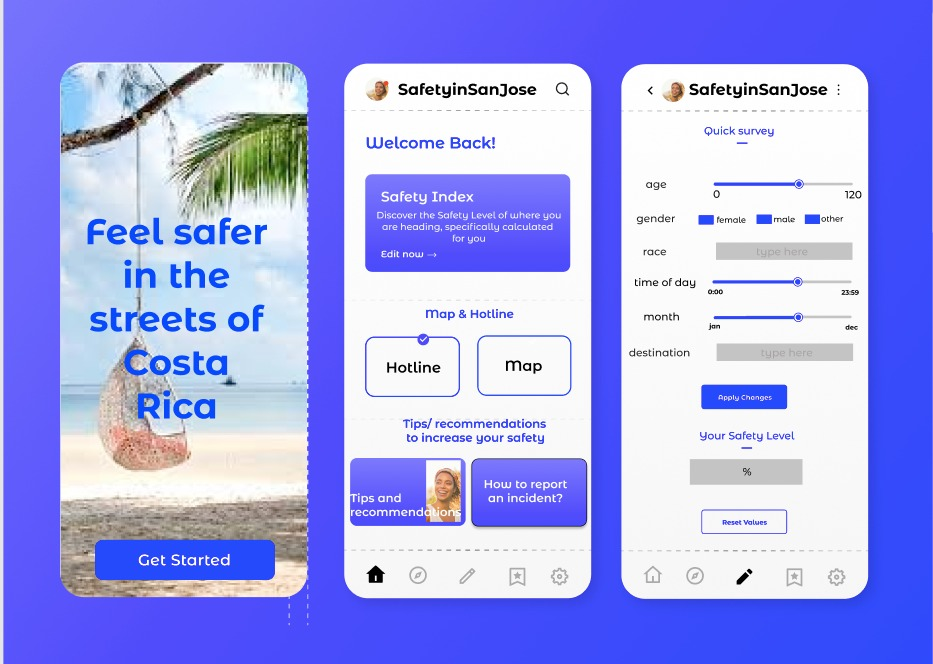

In [46]:
Image('App_1.jpg')

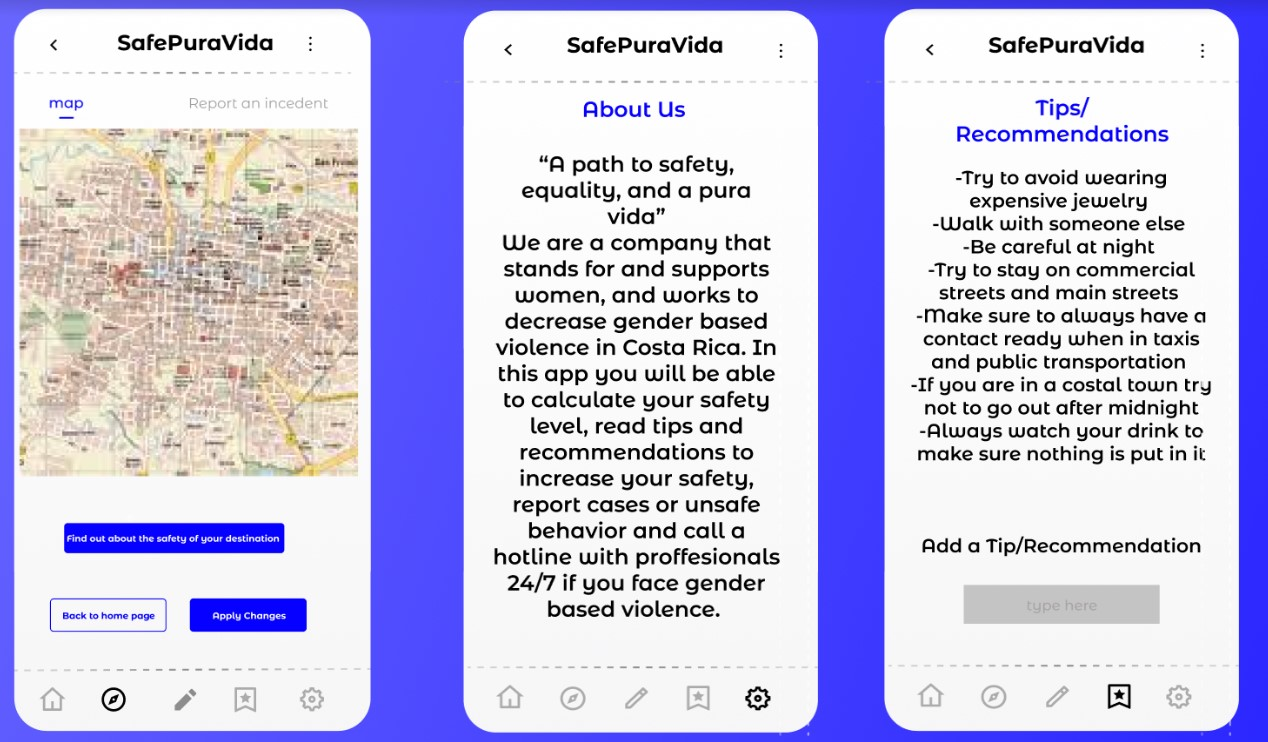

In [47]:
Image('App_2.jpg')

## 👓 References

**Literature:**

https://pinkerton.com/our-insights/blog/building-a-better-crime-score

https://pinkerton.com/our-insights/blog/what-is-the-most-accurate-measure-of-crime

https://pinkerton.com/products/pinkerton-crime-index/methodology

https://pinkerton.com/our-insights/blog/gaps-in-the-data

Epidemiology of rapes in Costa Rica: Characterization of victims, perpetrators and circumstances surrounding forced intercourse - ScienceDirect

Police Violence and the Underreporting of Crime - Gingerich - 2018 - Economics &amp; Politics - Wiley Online Library

CHAPTER 1 (unicri.us)

https://ec.europa.eu/commission/presscorner/detail/en/ip_22_1533

https://dialnet.unirioja.es/servlet/articulo?codigo=7350286

https://safetipin.com/report/guidelines-for-an-index-on-gender-inclusive-cities/


datasets and other sources from where data was extracted:

https://www.inec.cr/poblacion/estimaciones-y-proyecciones-de-poblacion

https://www.inec.cr/sites/default/files/documetos-biblioteca-virtual/repoblacev2017_0.pdf

https://www.oas.org/dil/esp/codigo_penal_costa_rica.pdf